In [19]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import h5py 
from scipy.stats import zscore
%matplotlib notebook

In [6]:
fname_nmf = '/groups/ahrens/ahrenslab/mika/Yu/20161012/20161012_1_1_cy221_HucRGeco6dpf/20161012_1_1_cy221_6dpf_0gain_wholebrain_20161012_113040/ana/Cells0_clust.mat'
base_dir = '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161012/20161012_1_1_cy221_6dpf_0gain_wholebrain_20161012_113040/'
fname_ref = base_dir + 'anat_reference.tif'
fname_km = base_dir + 'kmeans/'

In [8]:
from skimage.io import imread
ref = imread(fname_ref)

In [9]:
km_maps, km_centers = np.load(fname_km + 'kmeans_maps.npy'), np.load(fname_km + 'kmeans_centers.npy')

In [11]:
def load_components(fname):
    from h5py import File
    data = {}
    with File(fname) as f:
        to_load = ['CellH', 'CellW']        
        for v in to_load:
            data[v] = [f[i[0]][()] for i in f[v]]
    return data

def load_matfile(fname, base_name='data'):
    from h5py import File
    data = {}
    with File(fname) as f:    
        var_names = list(f[base_name].keys())
        for v in var_names:
            data[v] = np.squeeze(f[base_name][v].value)
    return data

def biexponential_kernel(kernel_width, rise, decay):
    from numpy import linspace, exp, zeros, hstack
    xrange = linspace(0, 10, kernel_width)
    kernel = exp(xrange * decay) - exp(xrange * rise)
    pad = zeros(kernel.shape)
    kernel = hstack([pad, kernel])
    kernel /= kernel.sum()
    return kernel

def ax_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
def composite(volume1, volume2, color1, color2):
    # normalize volume1 and volume2 to within (0,1)
    from numpy import zeros, r_
    v1 = volume1 - volume1.min()
    v1 /= v1.max()
    
    v2 = volume2 - volume2.min()
    v2 /= v2.max()
    
    cvol = zeros(r_[v1.shape, len(color1)])
    
    for rgb in range(len(color1)):
        cvol[:,:,:,rgb] = (color1[rgb] * v1 + color2[rgb] * v2).clip(0,1)
    return cvol

In [15]:
nmf = load_components(fname_nmf)

In [12]:
swim_fname = base_dir + 'ephys/data.mat'
raw_ephys_fname = base_dir + 'ephys/rawdata.mat'
swim_data = load_matfile(swim_fname)
raw_ephys_data = load_matfile(raw_ephys_fname, 'rawdata')
cam = swim_data['frame']
frame_signal = (np.diff(cam)[:-1] < 1) & (np.diff(cam)[1:] > 0)
frame_times = np.where(frame_signal)[0]
print('Frames detected in ephys: {0}'.format(len(frame_times)))

Frames detected in ephys: 6750


In [13]:
%%time
from scipy.signal import fftconvolve

# normalize the swim signal to [0,1]
swim_signal = swim_data['fltCh1'].copy()
swim_signal -= swim_signal.min()
swim_signal /= swim_signal.max()

starts = swim_data['swimStartIndT'].copy().astype('int')
stops = swim_data['swimEndIndT'].copy().astype('int')
swim_power = swim_data['swimPower1'].copy()

condition_signal =  raw_ephys_data['stimParam3']
gain_signal = raw_ephys_data['stimGain']
cl_thr = 30
cl_epoch = np.where(condition_signal < cl_thr)[0]
ol_epoch = np.where(condition_signal > cl_thr)[0]

cl_stops = stops[np.in1d(stops, cl_epoch, assume_unique=True)]
interbout = starts[1:] - stops[:-1]

# threshold in ephys samples for defining an inter-bout interval as GU
gu_thr = 40000
gu_events = np.where(interbout > gu_thr)[0]

# only keep stops in the open loop epoch
gu_events = gu_events[np.in1d(stops[gu_events], ol_epoch, assume_unique=True)]

# set the earliest timepoint to count as a giving up event
earliest = 30 * 6000
power_thr = 0.1
gu_events = gu_events[stops[gu_events] > earliest]
gu_events = gu_events[swim_power[gu_events] > power_thr]

gu_signal = np.zeros(swim_signal.shape)
gu_signal[stops[gu_events]] = 1

kern_swim = biexponential_kernel(12001, -10, -2)
kern_gu = biexponential_kernel(180001, -1.1, -3.9)
# clip the x axis of the gu kernel so that it doesn't overlap with the next swim bout
kern_gu = kern_gu[(len(kern_gu) // 2 - gu_thr ): (len(kern_gu) // 2 + gu_thr )]

# using fftconvolve is faster but less reliable for this purpose, for some reason.
flt_swim = fftconvolve(swim_signal - swim_signal.mean(), kern_swim, 'same')
flt_gu = fftconvolve(gu_signal, kern_gu, 'same')

from scipy.ndimage.interpolation import shift
# build regression matrices
swim_lags = [0]
gu_lags = [0]

matrix_length = len(frame_times)

swim_matrix = np.zeros([len(swim_lags), matrix_length])
gu_matrix = np.zeros([len(gu_lags), matrix_length])

for ind, slag in enumerate(swim_lags):
    swim_matrix[ind] = shift(flt_swim[frame_times[:matrix_length]], slag)

for ind, glag in enumerate(gu_lags):
    gu_matrix[ind] = shift(flt_gu[frame_times[:matrix_length]], glag)
    
motor_matrix = np.vstack([swim_matrix, gu_matrix])

CPU times: user 7.24 s, sys: 949 ms, total: 8.19 s
Wall time: 8.26 s


In [16]:
ts = nmf['CellH'][1]
ts.shape

(6750, 60)

In [17]:
import pywt

In [20]:
tmp = zscore(raw_ephys_data['ch1'])
wav = pywt.wavedec(tmp, 'db20')
thr = 2
rwav = list(map(lambda x: pywt.threshold(x,thr),
wav))
rec = pywt.waverec(rwav, 'db20')

<IPython.core.display.Javascript object>


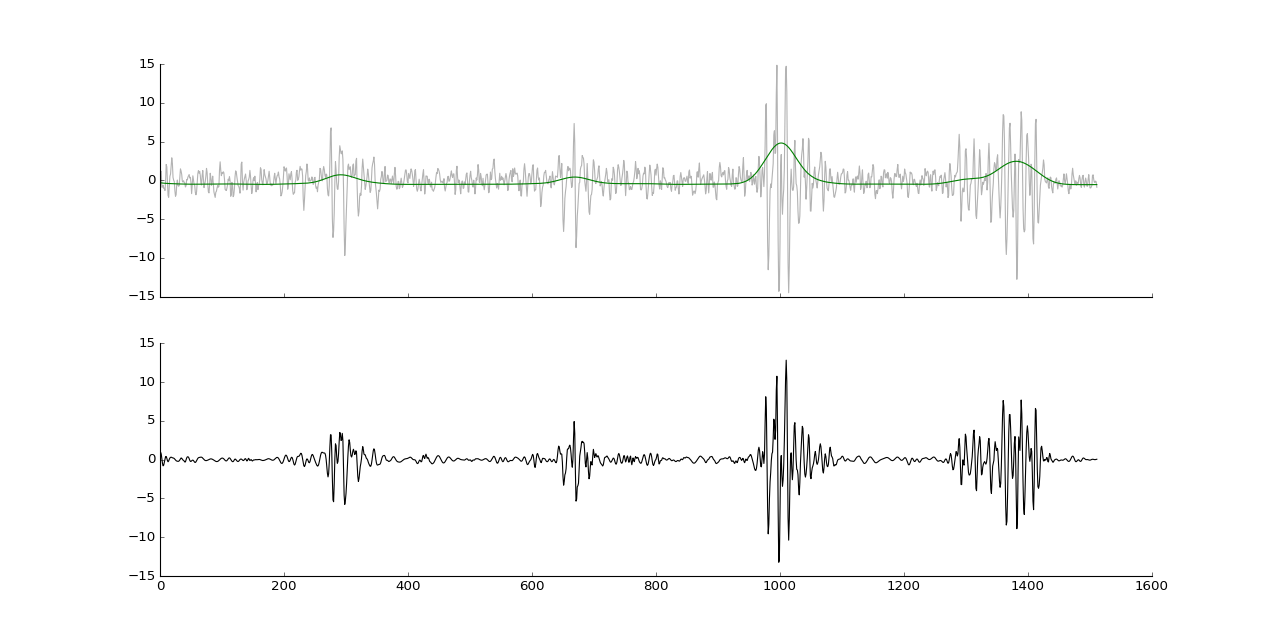

In [25]:
nr = 2
fig, axs = plt.subplots(nrows=nr, figsize=(16,4 * nr), sharex=True)
plr = slice(frame_times[661] + 3000, frame_times[663] - 1000)
axs[0].plot(tmp[plr], color=[.7,.7,.7])
axs[0].plot(zscore(swim_signal[plr]), color='g')
axs[1].plot(rec[plr],'k');
[ax_format(ax) for ax in axs];

<IPython.core.display.Javascript object>


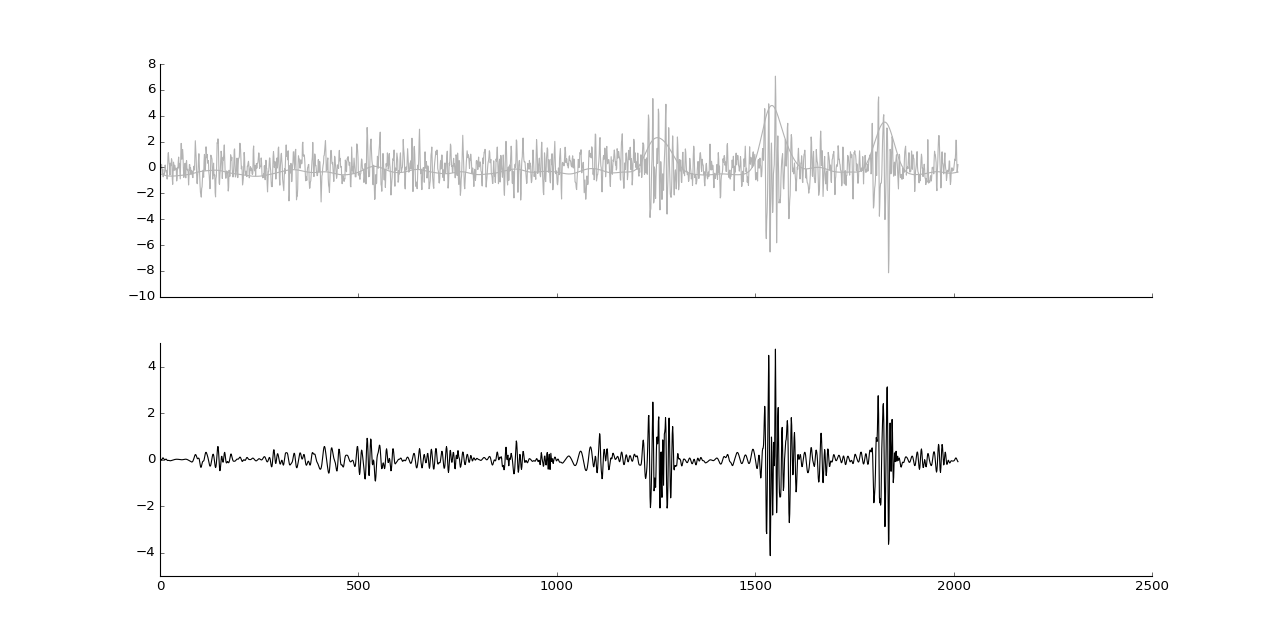

In [24]:
nr = 2
fig, axs = plt.subplots(nrows=nr, figsize=(16,4 * nr), sharex=True)
plr = slice(frame_times[640] + 3000, frame_times[642] - 500)
axs[0].plot(tmp[plr], color=[.7,.7,.7])
axs[0].plot(zscore(swim_signal[plr]), color=[.7,.7,.7])
axs[1].plot(rec[plr],'k');
[ax_format(ax) for ax in axs];

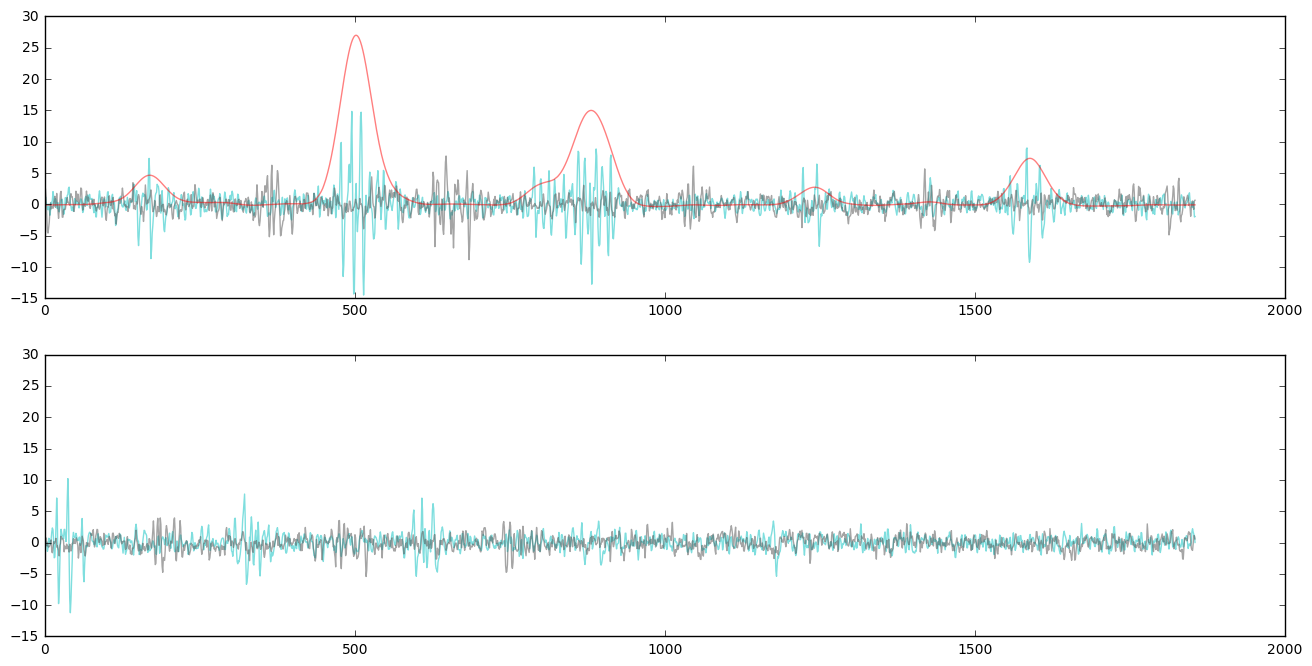

In [154]:
%matplotlib inline
from scipy.stats import zscore
nr = 2
fig, axs = plt.subplots(nrows=nr, figsize=(16, nr * 4), sharey=True)
plr_1 = np.arange(frame_times[661] + 3500, frame_times[662] + 2600) + 0
plr_2 = np.arange(frame_times[651] + 3500, frame_times[652] + 2600) + 1500

axs[0].plot(zscore(raw_ephys_data['ch1'])[plr_1], color='c', alpha = .5)
axs[0].plot(zscore(raw_ephys_data['ch2'])[plr_1], color=[.3,.3,.3], alpha = .5)
axs[0].plot(zscore(swim_signal)[plr_1], color='r', alpha = .5)

axs[1].plot(zscore(raw_ephys_data['ch1'])[plr_2], color='c', alpha = .5)
axs[1].plot(zscore(raw_ephys_data['ch2'])[plr_2], color=[.3,.3,.3], alpha = .5)

#[ax.axis('tight') for ax in axs]
#[ax_format(ax) for ax in axs]

In [30]:
ts = km_centers[1].T
from scipy.cluster.hierarchy import dendrogram, linkage
l = linkage( (1 + ts.T) ** .5, method='ward')

<IPython.core.display.Javascript object>


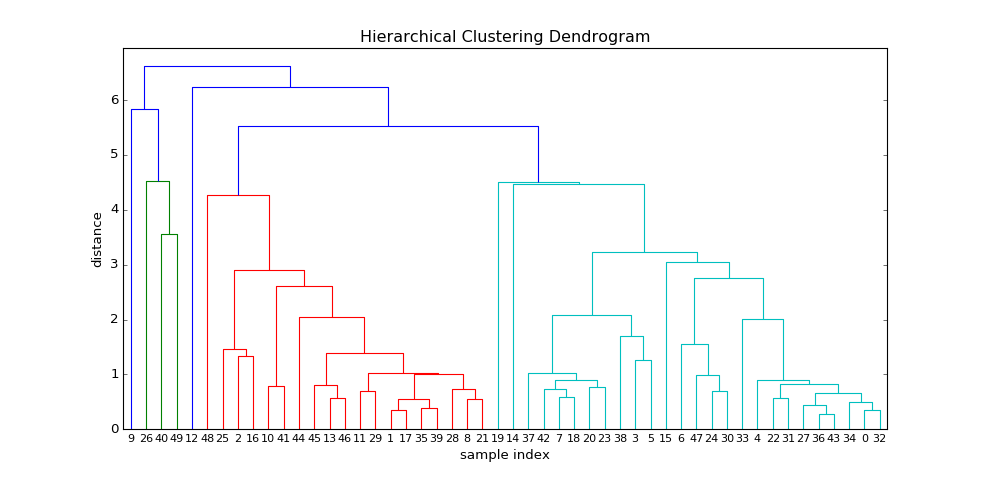

In [37]:
# calculate full dendrogram
plt.figure(figsize=(14, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
den = dendrogram(
    l,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10,  # font size for the x axis labels
)
plt.show()

In [27]:
from fish.image.vol import proj_plot

<IPython.core.display.Javascript object>


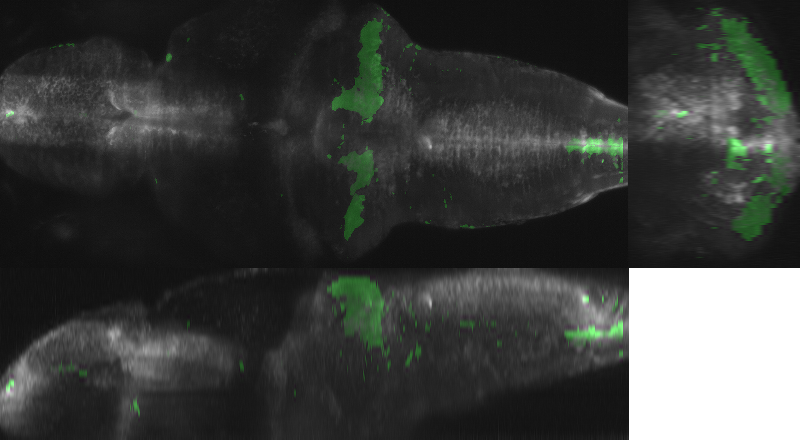

<IPython.core.display.Javascript object>


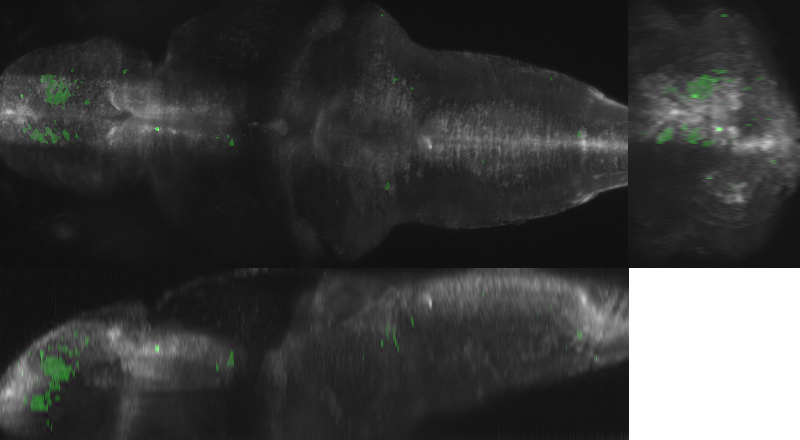

<IPython.core.display.Javascript object>


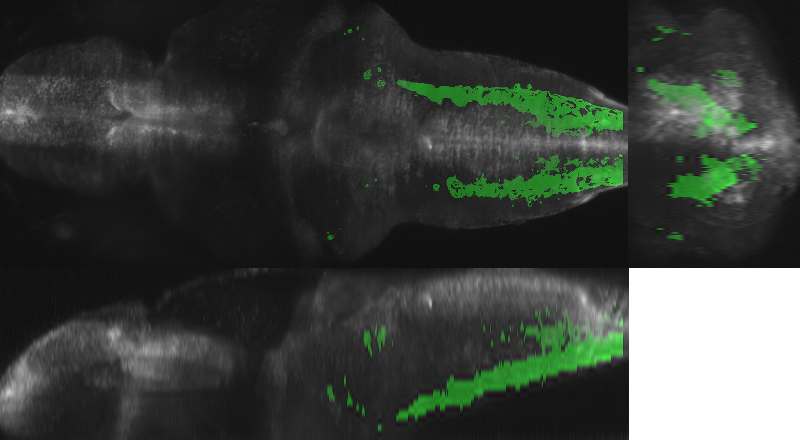

<IPython.core.display.Javascript object>


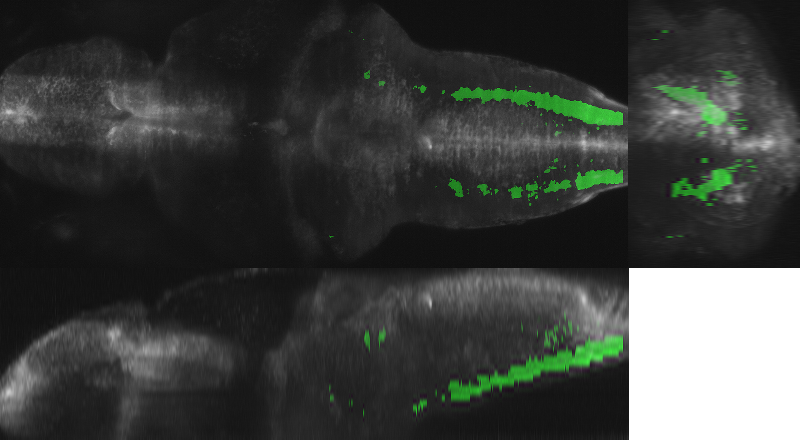

<IPython.core.display.Javascript object>


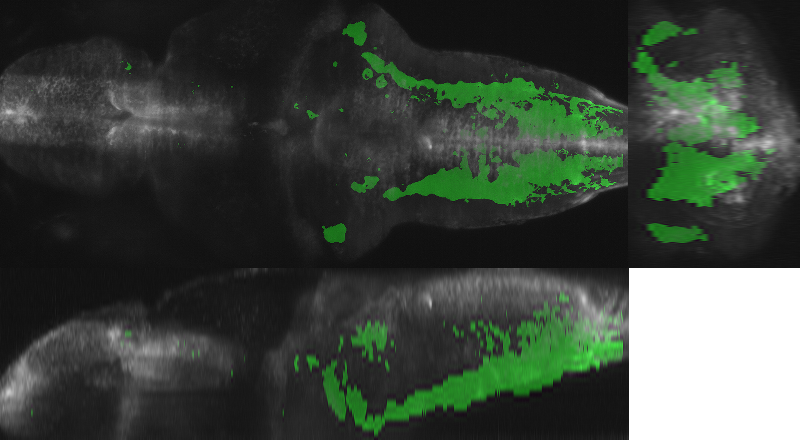

<IPython.core.display.Javascript object>


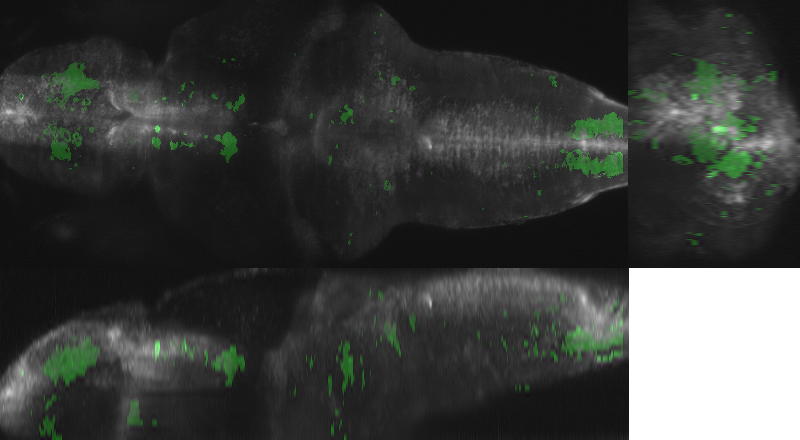

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ae35aa38898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2ae35b111048>]], dtype=object)

In [28]:
cmps = (37,42,7, 18,20,23, 38,3,5)
tmp = np.array([km_maps[1] == x for x in cmps]).sum(0)
cvol = composite(ref[:,::2,::2] ** .5, ref[:,::2,::2] * tmp, [.8,.8,.8], [0,.6,0])
proj_plot(cvol, np.max, aspect=(8,1,1), figsize=10)

cmps = (25,2,16)
tmp = np.array([km_maps[1] == x for x in cmps]).sum(0)
cvol = composite(ref[:,::2,::2] ** .5, ref[:,::2,::2] * tmp, [.8,.8,.8], [0,.6,0])
proj_plot(cvol, np.max, aspect=(8,1,1), figsize=10)

cmps = (45,13,46)
tmp = np.array([km_maps[1] == x for x in cmps]).sum(0)
cvol = composite(ref[:,::2,::2] ** .5, ref[:,::2,::2] * tmp, [.8,.8,.8], [0,.6,0])
proj_plot(cvol, np.max, aspect=(8,1,1), figsize=10)

cmps = (10,41)
tmp = np.array([km_maps[1] == x for x in cmps]).sum(0)
cvol = composite(ref[:,::2,::2] ** .5, ref[:,::2,::2] * tmp, [.8,.8,.8], [0,.6,0])
proj_plot(cvol, np.max, aspect=(8,1,1), figsize=10)

cmps = (1,17, 35)
tmp = np.array([km_maps[1] == x for x in cmps]).sum(0)
cvol = composite(ref[:,::2,::2] ** .5, ref[:,::2,::2] * tmp, [.8,.8,.8], [0,.6,0])
proj_plot(cvol, np.max, aspect=(8,1,1), figsize=10)

cmps = (28,8, 21)
tmp = np.array([km_maps[1] == x for x in cmps]).sum(0)
cvol = composite(ref[:,::2,::2] ** .5, ref[:,::2,::2] * tmp, [.8,.8,.8], [0,.6,0])
proj_plot(cvol, np.max, aspect=(8,1,1), figsize=10)

<IPython.core.display.Javascript object>


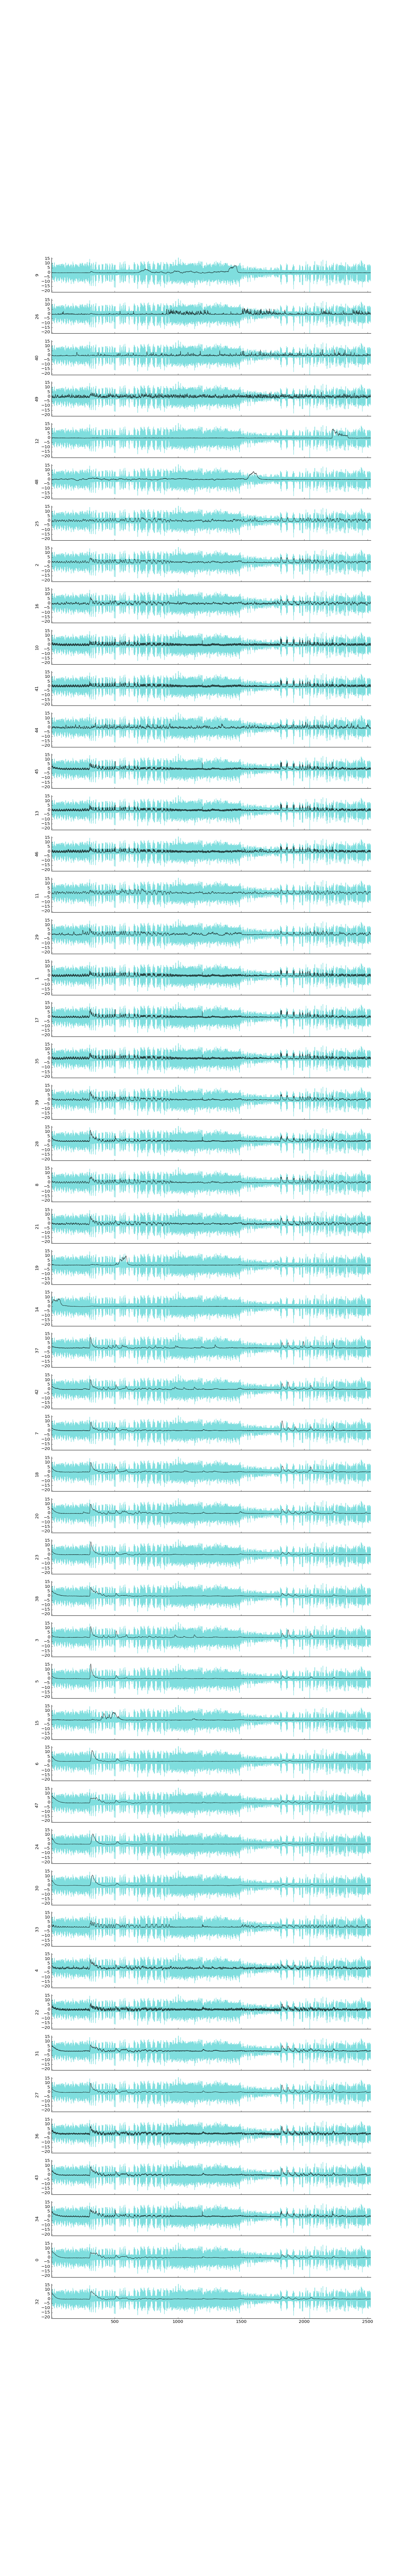

In [46]:
order = np.array(den['ivl']).astype('int')
nr = len(order)
fig, axs = plt.subplots(nrows = nr, figsize=(16,2 * nr), sharex=True)
plr_im = np.arange(0, 5500)
ds_ep = 10
plr_ep = np.arange(frame_times[plr_im[0]], frame_times[plr_im[-1]], ds_ep)
fs_ep = 6000
sig1 = zscore(raw_ephys_data['ch1'])
sig2 = zscore(ts, axis = 0)

for r in np.arange(nr): 
    cur_cmp = order[r]
    ax = axs[r]
    ax.plot(plr_ep / fs_ep, sig1[plr_ep], 'c', alpha = .5)
    ax.plot(frame_times[plr_im] / fs_ep, sig2[plr_im, cur_cmp],'k', alpha = .7);
    ax.set_ylabel(str(cur_cmp))
    ax.axis('tight')
    ax_format(ax)

In [58]:
wave_cmp = km_centers[1][37]

In [60]:
def filt(w, btype='lowpass', order=5):
    from scipy.signal import filtfilt, bessel
    b,a = bessel(order, w, btype)
    return lambda v: filtfilt(b, a, v)

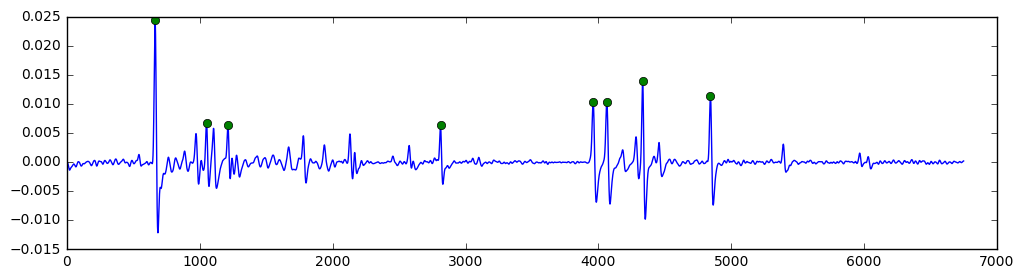

In [68]:
import peakutils as pk
%matplotlib inline
nr = 1
fig,axs = plt.subplots(nrows=nr, figsize=(12, 3 * nr))
plr = np.arange(0, 6500)
pk_signal = np.diff(filt(.1)(wave_cmp))
pks = pk.indexes(pk_signal, thres=.5)
axs.plot(pk_signal)
axs.plot(pks, pk_signal[pks],'o')


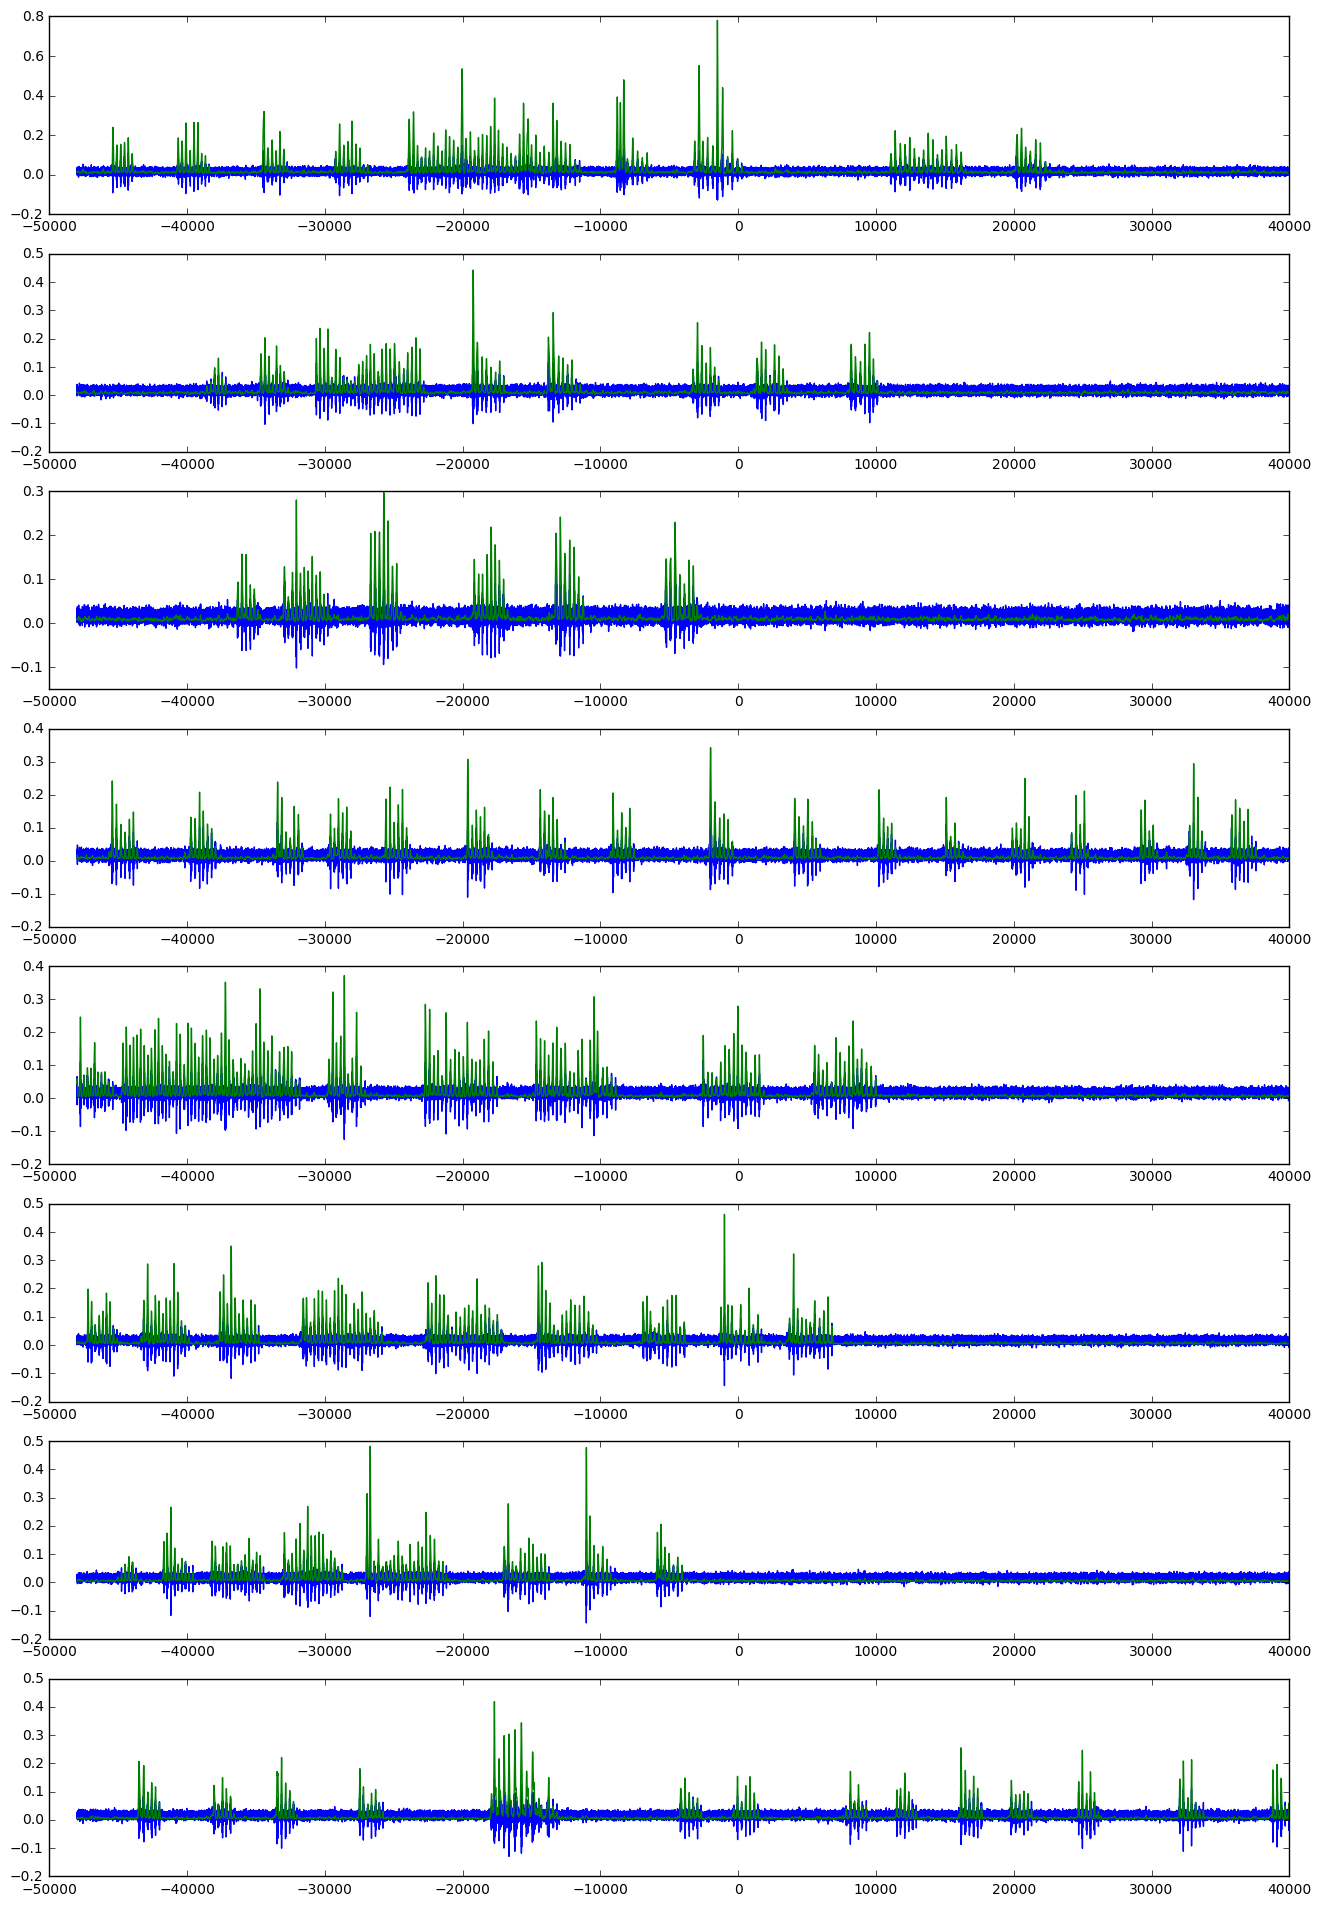

In [82]:
nr = len(pks)
fig, axs = plt.subplots(nrows=nr, figsize=(16,3 * nr))

swim = raw_ephys_data['ch1']
window = np.arange(-48000, 40000)
for ind, p in enumerate(pks):
    axs[ind].plot(window, swim[window + frame_times[p]])
    axs[ind].plot(window, swim_signal[window + frame_times[p]])